This script is a frequency analysis of the frequncy data from Fingrid

In [1]:
import pandas as pd
import os

In [2]:
folder = 'data/frequency_data/2025-04/2025-04'
# read all files in folder
file_list = os.listdir(folder)
# 
f_ffr_limit = 49.6  # frequency where FFR is activated
f_fcr_d_limit = 49.9 # frequency where FCR-D is activated
for file in file_list:
    # first column is timestamp
    df = pd.read_csv(os.path.join(folder, file), header=0, index_col=0, parse_dates=True)
    df.columns = ['frequency']  # set name of column
    fs_ffr = df[df['frequency'] <= f_ffr_limit]
    fs_fcr_d = df[df['frequency'] <= f_fcr_d_limit]
    print(f'File: {file[-9:]}, number of FFR events: {len(fs_ffr)}/{len(df)}, number of FCR-D events: {len(fs_fcr_d)}/{len(df)}')

File: 04-01.csv, number of FFR events: 0/863909, number of FCR-D events: 1197/863909
File: 04-02.csv, number of FFR events: 0/863925, number of FCR-D events: 5822/863925
File: 04-03.csv, number of FFR events: 0/863939, number of FCR-D events: 1771/863939


KeyboardInterrupt: 

In [2]:
# do same for procurement
df = pd.read_csv('data/data_ffr_fcr_procurement_2024_25.csv', sep=';')
df.drop('endTime', inplace=True, axis=1)
df.rename(columns={'startTime': 'Datum'}, inplace=True)
df["Datum"] = pd.to_datetime(df["Datum"], format='mixed')
# remove timezone info
df["Datum"] = df["Datum"].dt.tz_localize(None)
df.set_index('Datum', inplace=True)
df.columns = ['FFR', 'FCR-D']
df.head()

,FFR,FCR-D
Datum,,
2024-07-31 22:00:00,0.0,100.7
2024-07-31 23:00:00,0.0,86.0
2024-08-01 00:00:00,0.0,66.4
2024-08-01 01:00:00,0.0,36.7
2024-08-01 02:00:00,0.0,39.5


In [3]:
# take month of april
start_date, end_date = pd.to_datetime(['04/01/2025', '05/01/2025'])
df_april = df[(df.index >= start_date) & (df.index < end_date)]
# count number of events where FFR > 0
ffr_name = df.columns[0]
ffr_events = df_april[df_april[ffr_name] > 0]
print(f'Number of FFR procurement events in April 2025: {len(ffr_events)}/{len(df_april)}')

Number of FFR procurement events in April 2025: 233/720


<Axes: xlabel='Datum'>

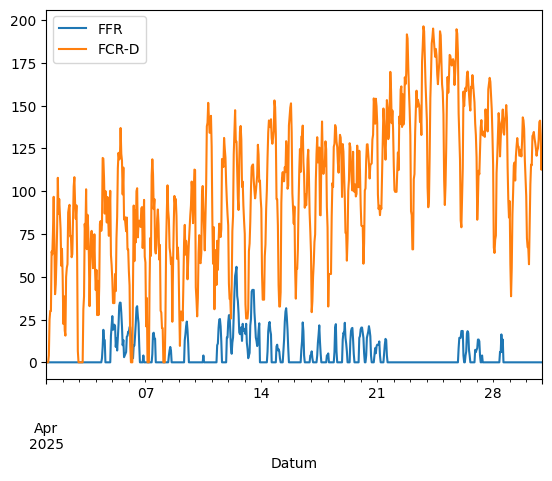

In [4]:
df_april.plot()

In [5]:
start_date, end_date = pd.to_datetime(['2025-04-06 10:00:00', '2025-04-06 11:00:00'])
df_april.loc[start_date:end_date, 'FFR']

Datum
2025-04-06 10:00:00    22.9
2025-04-06 11:00:00    31.9
Name: FFR, dtype: float64

In [6]:
from src.time_varying_dc_gain import get_wind_solar_dc_gains

In [7]:
wind_solar_dc_gains, probs_15_min, prices = get_wind_solar_dc_gains(hourly_average=True)

In [8]:
prices.loc[start_date:end_date]

,FFR_price,FCR_D_up_price
2025-04-06 10:00:00,48.85,2.0
2025-04-06 11:00:00,48.90,2.0


In [9]:
time_stamps = [start_date]
from src.get_pv_wind_probs import get_errors, get_prod_forecast_data

In [10]:
k_errs = {}
K_errors = 10
for t in time_stamps:
    k_errs[t] = get_errors(K_errors, t.hour)  # tuple of wind_errors, solar_errors

In [11]:
k_errs[t]

[(0.03342394220108015, -0.004038215305820943),
 (0.03095535495657102, 0.005318625036934893),
 (0.03905856652736017, 0.010834236186348933),
 (0.0026591134821042778, 0.004727666699497701),
 (-0.0031012444045814304, 0.003545750024623262),
 (0.10699595836760967, -0.04156406973308391),
 (0.26167299919937703, -0.024426277947404693),
 (0.06141547925946511, -0.07958238944154439),
 (0.09641865698949287, -0.08155225056633508),
 (-0.10666305331708242, 0.038609278045897755)]

In [12]:
other, wind_solar_forecast = get_prod_forecast_data()

In [13]:
other.loc[t]

Wind     0.081415
Solar    0.488772
Name: 2025-04-06 10:00:00, dtype: float64

In [14]:
wind_fc, solar_fc = wind_solar_forecast.loc[t][['Wind_forecast', 'Solar_forecast']]
print(f'At {t}, wind forecast: {wind_fc} MW, solar forecast: {solar_fc} MW')

At 2025-04-06 10:00:00, wind forecast: 0.12649360189508263 MW, solar forecast: 0.49527233330050235 MW


In [15]:
df_forecast = wind_solar_forecast
df = other

In [16]:
# create errors
error_wind = df_forecast['Wind_forecast'] - df['Wind']
error_solar = df_forecast['Solar_forecast'] - df['Solar']
# remove nan values
error_wind = error_wind[~error_wind.isna()]
error_solar = error_solar[~error_solar.isna()]

In [17]:
t2 = t + pd.Timedelta(hours=10, days=0)
error_wind[t:t2]

2025-04-06 10:00:00    0.045079
2025-04-06 11:00:00    0.054523
2025-04-06 12:00:00    0.070267
2025-04-06 13:00:00    0.073031
2025-04-06 14:00:00    0.074802
2025-04-06 15:00:00    0.067369
2025-04-06 16:00:00    0.063878
2025-04-06 17:00:00    0.002623
2025-04-06 18:00:00   -0.065982
2025-04-06 19:00:00   -0.117564
2025-04-06 20:00:00   -0.172312
Freq: h, dtype: float64

In [18]:
thresh = .4
error_wind_thresh = error_wind[error_wind >= thresh]
error_solar_thresh = error_solar[error_solar >= thresh]

In [19]:
error_solar_thresh

Series([], Freq: h, dtype: float64)

In [21]:
error_solar[t:t2]

2025-04-06 10:00:00    0.006501
2025-04-06 11:00:00   -0.001502
2025-04-06 12:00:00   -0.003152
2025-04-06 13:00:00   -0.037969
2025-04-06 14:00:00   -0.028809
2025-04-06 15:00:00   -0.008840
2025-04-06 16:00:00   -0.009455
2025-04-06 17:00:00    0.000000
2025-04-06 18:00:00    0.000000
2025-04-06 19:00:00    0.000000
2025-04-06 20:00:00    0.000000
Freq: h, dtype: float64

In [22]:
error_solar[t]

np.float64(0.00650054171180936)

In [51]:
# compute MSE
def compute_mse(df_expected, df_actual):
    return ((df_expected - df_actual) ** 2).mean()
mse_wind = compute_mse(df_forecast['Wind_forecast'], df['Wind'])
mse_solar = compute_mse(df_forecast['Solar_forecast'], df['Solar'])
print(f'MSE Wind: {mse_wind}, MSE Solar: {mse_solar}')

MSE Wind: 0.007597951233733052, MSE Solar: 0.0010141317852021435


In [52]:
# compute mse of wind forecast but first make it zero mean error
mean_error_wind = error_wind.mean()
error_wind_zero_mean = error_wind - mean_error_wind
mse_wind_zero_mean = (error_wind_zero_mean ** 2).mean()
print(f'MSE Wind zero mean: {mse_wind_zero_mean}')

MSE Wind zero mean: 0.006682354116697844


In [50]:
error_wind.describe()

count    8760.000000
mean        0.030259
std         0.081750
min        -0.267820
25%        -0.016626
50%         0.020405
75%         0.066329
max         0.498070
dtype: float64

In [24]:
error_solar.describe()

count    8760.000000
mean       -0.008770
std         0.030616
min        -0.339309
25%        -0.004949
50%         0.000000
75%         0.000000
max         0.139811
dtype: float64

In [25]:
results = pd.read_csv('pics/v_case/dvpp_info_DPF_FFR-FCR.csv')
results

,time_stamps,k_dc_gain,real_dc_gain,k_bid,opt_bid,k_reward,expected_reward,real_reward,FFR_price,FCR-D up_price,k_bess_soc
0,2025-04-06 10:00:00,11.754160,11.590142,5.514724,5.256091,140.211849,133.636119,141.395636,48.85,2.0,4
1,2025-04-06 10:00:00,12.752894,11.590142,5.921569,5.256091,150.555895,133.636119,141.395636,48.85,2.0,4
2,2025-04-06 10:00:00,12.459846,11.590142,5.752319,5.256091,146.252722,133.636119,141.395636,48.85,2.0,4
3,2025-04-06 10:00:00,11.264900,11.590142,5.384153,5.256091,136.892089,133.636119,141.395636,48.85,2.0,4
4,2025-04-06 10:00:00,11.454919,11.590142,5.500879,5.256091,139.859850,133.636119,141.395636,48.85,2.0,4
5,2025-04-06 10:00:00,15.711479,11.590142,6.659664,5.256091,169.321960,133.636119,141.395636,48.85,2.0,4
6,2025-04-06 10:00:00,16.048691,11.590142,6.829646,5.256091,173.643762,133.636119,141.395636,48.85,2.0,4
7,2025-04-06 10:00:00,12.459145,11.590142,5.751914,5.256091,146.242425,133.636119,141.395636,48.85,2.0,4
8,2025-04-06 10:00:00,10.808015,11.590142,5.256091,5.256091,133.636119,133.636119,141.395636,48.85,2.0,4
9,2025-04-06 10:00:00,13.095933,11.590142,5.925073,5.256091,150.644976,133.636119,141.395636,48.85,2.0,4


In [26]:
from src.game_theory_helpers import powerset, is_convex_game, get_loo, get_shapley_value, get_nash_bargaining_solution, get_banzhaf_value, core_nonempty, game_is_superadditive
from src.nucleolus import get_nucleolus

from src.least_core_nucleolus import get_least_core_nucleolus

In [27]:
def add_reward_mechanisms(df: pd.DataFrame, players: list,
                    add_LOO=False, add_nucleolus=True,
                    add_core_empty_nucleolus=False) -> pd.DataFrame:
    """
    Add shapely and nbs values to dataframe df, and optionally LOO and nucleolus.

    df: Dataframe with values for each coalition
    players: list of players
    """
    new_index = pd.MultiIndex.from_product((df.index, ['value', 'shapley', 'nbs']))
    if add_LOO:
        new_index = pd.MultiIndex.from_product((df.index, ['value', 'shapley', 'nbs', 'loo']))
        if add_nucleolus:
            new_index = pd.MultiIndex.from_product((df.index, ['value', 'shapley', 'nbs', 'loo', '0. nucleolus']))
    df_new = pd.DataFrame(pd.NA, index=new_index, columns=df.columns)
    for idx, row in df.iterrows():
        df_new.loc[(idx, 'value')] = row
        v = {frozenset(k): val for k, val in row.items()}
        # add empty set
        v[frozenset()] = 0
        shapley, nbs = get_shapley_value(v, players), get_nash_bargaining_solution(v, players)
        df_new.loc[(idx, 'shapley'), list((k,) for k in shapley.keys())] = list(shapley.values())
        df_new.loc[(idx, 'nbs'), list((k,) for k in nbs.keys())] = list(nbs.values())
        if add_LOO:
            loo = get_loo(v, players)
            df_new.loc[(idx, 'loo'), list((k,) for k in loo.keys())] = list(loo.values())
        if add_core_empty_nucleolus:
            print(v, players)
            try:
                nucleolus = get_least_core_nucleolus(v, players)
                df_new.loc[(idx, '0. nucleolus'), list((k,) for k in nucleolus.keys())] = list(nucleolus.values())
            except Exception as e:
                print(f"Error computing nucleolus for {idx}: {e}")
        elif add_nucleolus:
            # is_core_empty = core_nonempty(v, players)
            is_superadditive = game_is_superadditive(v, players)
            if not is_superadditive:
                print(f"Game is not superadditive for {idx}, skipping nucleolus computation.")
                continue
            try:
                nucleolus = get_nucleolus(v, players)
                df_new.loc[(idx, '0. nucleolus'), list((k,) for k in nucleolus.keys())] = list(nucleolus.values())
            except Exception as e:
                print(f"Error computing nucleolus for {idx}: {e}")
                # remove the nucleolus row
                # df_new = df_new.drop(index=(idx, 'nucleolus'))
    return df_new

In [28]:
results['k_dc_gain'].describe()

count    10.000000
mean     12.780998
std       1.781895
min      10.808015
25%      11.529729
50%      12.459496
75%      13.010173
max      16.048691
Name: k_dc_gain, dtype: float64

In [29]:
df_expected = pd.read_csv('pics/v_case/expected_values_DPF.csv', index_col=0, header=[0,1,2])
df_realized = pd.read_csv('pics/v_case/values_DPF.csv', index_col=0, header=[0,1,2])

In [30]:
df_expected.columns = [tuple(c for c in col if c!='nan') for col in df_expected.columns.values]
df_realized.columns = [tuple(c for c in col if c!='nan') for col in df_realized.columns.values]
df_expected = df_expected.iloc[:, 1:]
df_realized = df_realized.iloc[:, 1:]

In [31]:
df_expected

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FFR-FCR,62.71882,8.09976,0.0,71.55999,121.00642,25.33911,133.63612


In [32]:
n_players = 3
players = list(str(x[0]) for x in df_expected.columns[:n_players])
players

['PV', 'Wind', 'BESS']

In [34]:
print('Computing Reward Mechanisms for Dynamic')
df_expected = add_reward_mechanisms(df_expected, players, add_LOO=True)
df_expected

Computing Reward Mechanisms for Dynamic


(PV,)    (Wind,)    (BESS,) (PV, Wind) (PV, BESS)  \
FFR-FCR value          62.71882    8.09976        0.0   71.55999  121.00642   
        shapley       87.749718  12.606533  33.279868       <NA>       <NA>   
        nbs              83.658   29.03894   20.93918       <NA>       <NA>   
        loo           79.082883   9.222721  45.330516       <NA>       <NA>   
        0. nucleolus  85.507915   10.36473  37.763475       <NA>       <NA>   

                     (Wind, BESS) (PV, Wind, BESS)  
FFR-FCR value            25.33911        133.63612  
        shapley              <NA>             <NA>  
        nbs                  <NA>             <NA>  
        loo                  <NA>             <NA>  
        0. nucleolus         <NA>             <NA>

In [35]:
df_realized[df_realized < 0] = 0  # set values below zero to zero

In [36]:
df_realized_mechanisms = add_reward_mechanisms(df_realized, players, add_LOO=True)
df_realized_mechanisms

(PV,)    (Wind,)    (BESS,) (PV, Wind) (PV, BESS)  \
FFR-FCR value          69.99711   12.68347        0.0    79.3195  127.14195   
        shapley       93.821657  15.002247  32.571737       <NA>       <NA>   
        nbs           89.568797  32.255157  19.571687       <NA>       <NA>   
        loo           84.862307  10.556929  45.976404       <NA>       <NA>   
        0. nucleolus   92.28799   13.46858   35.63907       <NA>       <NA>   

                     (Wind, BESS) (PV, Wind, BESS)  
FFR-FCR value            26.81677        141.39564  
        shapley              <NA>             <NA>  
        nbs                  <NA>             <NA>  
        loo                  <NA>             <NA>  
        0. nucleolus         <NA>             <NA>

In [42]:
df_expected = pd.read_csv('pics/v_case_max_error/expected_values_DPF.csv', index_col=0, header=[0,1,2])
df_realized = pd.read_csv('pics/v_case_max_error/values_DPF.csv', index_col=0, header=[0,1,2])

In [43]:
df_expected.columns = [tuple(c for c in col if c!='nan') for col in df_expected.columns.values]
df_realized.columns = [tuple(c for c in col if c!='nan') for col in df_realized.columns.values]
df_expected = df_expected.iloc[:, 1:]
df_realized = df_realized.iloc[:, 1:]

In [48]:
df_expected.values

array([[ 0.14028, 14.85962,  0.     , 15.02361,  0.     , 22.08863,
        22.21828]])

In [44]:
df_realized

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FFR-FCR,0,-44.57887,0,-45.07084,0,-66.26588,-66.65484


In [45]:
df_realized_mechs = add_reward_mechanisms(df_realized, players, add_LOO=True, add_core_empty_nucleolus=True)

{frozenset({'PV'}): 0.0, frozenset({'Wind'}): -44.57887, frozenset({'BESS'}): 0.0, frozenset({'Wind', 'PV'}): -45.07084, frozenset({'PV', 'BESS'}): 0.0, frozenset({'Wind', 'BESS'}): -66.26588, frozenset({'Wind', 'PV', 'BESS'}): -66.65484, frozenset(): 0} ['PV', 'Wind', 'BESS']
first stage nucleolus values and excess: {'PV': 0.0, 'Wind': -55.616855, 'BESS': -11.037984999999995} and [11.037984999999995]
first stage nucleolus values and excess: {'PV': -0.24598499999999568, 'Wind': -55.616855, 'BESS': -10.792} and [11.037984999999995, 10.792]
first stage nucleolus values and excess: {'PV': -0.24598499999999746, 'Wind': -55.616855, 'BESS': -10.792} and [11.037984999999995, 10.792, 0.24598499999999746]
first stage nucleolus values and excess: {'PV': -0.24598499999999746, 'Wind': -55.616855, 'BESS': -10.792} and [11.037984999999995, 10.792, 0.24598499999999746, 0.14297500000000696]


In [46]:
df_realized_mechs

(PV,)    (Wind,)    (BESS,) (PV, Wind) (PV, BESS)  \
FFR-FCR value               0.0  -44.57887        0.0  -45.07084        0.0   
        shapley       -0.211648 -55.634023 -10.809168       <NA>       <NA>   
        nbs          -11.037985 -55.616855        0.0       <NA>       <NA>   
        loo                   0          0          0       <NA>       <NA>   
        0. nucleolus  -0.245985 -55.616855    -10.792       <NA>       <NA>   

                     (Wind, BESS) (PV, Wind, BESS)  
FFR-FCR value           -66.26588        -66.65484  
        shapley              <NA>             <NA>  
        nbs                  <NA>             <NA>  
        loo                  <NA>             <NA>  
        0. nucleolus         <NA>             <NA>